# Merge of IGN and Bugianen, Mercantour area

This file is identical to `merge_frit4`/`3` except with `fritN=1`, with an additional hack in the merge code, and this description :-)

* French side: IGNt1 ie a specific area downloaded from geoportail
* Italian side: Bugianen 2205 - roughly Cuneese & Monregalese
  (all merged, check `maki-Sorbetto-merge.ipynb`)

Steps overview
* Cut Bugianen_merged to the same latitudes as the IGN side
* z14/z15/16 - merge along border
* z13: clean & merge it < fr
* z<12: add IGN basemap as Bugianen has nothing

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from os.path import exists, join as pjoin, realpath
NBROOT = realpath(os.curdir)

import logging
logging.basicConfig(level=logging.DEBUG)
logging.getLogger('PIL').level = logging.INFO # PIL.PngImagePlugin

import sys
sys.path.append(realpath('..'))
sys.path.append(realpath('../../eslope/development/src'))

import json
from pathlib import Path
from time import time
from urllib.error import HTTPError
from urllib.request import urlopen, urlretrieve
from subprocess import check_call, CalledProcessError

try:
    # like os.system but with live output
    from IPython.utils.process import system
    def check_run(cmd):  # type:ignore
        r = system(cmd)
        if r: raise CalledProcessError(r, cmd)
        return r
except ImportError:
    def check_run(cmd):
        return check_call(cmd, shell=True)

#external
#!pip install shapely
import shapely
from shapely.geometry import mapping, shape, GeometryCollection, Polygon, Point
from shapely.ops import cascaded_union
import numpy as np
from IPython.display import display, Image
from PIL import Image as Img
import mercantile as T
from osgeo import gdal
gdal.UseExceptions()

# own
import mbt_util as M
import bbox
from mbt_util import mbt_merge, mbt_info
from src import img_util as G, geometry as GY, \
    mbt_download as MD, mbt_partial as MP, mbt_pyramid as MY, swisstopo as SS


In [3]:
mbtnames_fr = {
    1: 'IGNt1-Mercantour-Ubaye-Antibes-Embrun.mbtiles',  # 1.3GB
    # Préalpes, Trois-Evéchés, Pelat, Mercantour-Argentera, Parpaillon, Chambeyron
    2: 'IGNt2-Digne-Aups-Eguilles-Gap.mbtiles',  # 1.3 GB
    # Préalpes de Digne, Lubéron, Vaucluse, Baronnies, Bochaine, Diois-S
    3: 'IGNt3-Vercors-Ecrins-Cerces.mbtiles',  # 1.2
    # Vercors, Taillefer, Dévoluy, Ecrins, Cerces, Queyras, Escreins
    # coupé en 2 t3/t4: Grandes Rousses, Arves, Cerces
    4: 'IGNt4-Chartreuse-Vanoise Chambery-Bardon.mbtiles',  # 1 GB
    # Chartreuse, Belledonne, Grandes Rousses N, Arves N, Cerces N, Lauzière, Vanoise, Mont-Cenis
    5: 'IGNt5-MontBlanc-Chambery-Evian.mbtiles'  # 1.1 GB
    # Bauges, Beaufortain, Bornes, Aravis, Mont-Blanc, Aiguilles Rouges, Giffre, Chablais
}
mbtnames_merged = {
    1: 'frit1-Mercantour-Ubaye-Cuneese',
    2: '',  # IGNt2 - no change
    3: 'frit3-Vercors-Ecrins-Queyras-Cozie',
    # it3: Alpes Cozie (Cotiennes) ; Monviso
    4: 'frit4-Grenoble-Savoie-Susa-Lanzo-GParadiso',
    # Chartreuse, Belledonne, Grandes Rousses N, Arves N, Cerces N, Lauzière, Vanoise, Mont-Cenis
    # it: Alpes Grées/Alpi Graie: Lanzo, Susa
    5: 'frit5-Mont-Blanc-Leman-Cervino-Cogne'
    # it: Gran Paradiso N, Cervino
}

In [4]:
# This could be useful to restrict the area to merge to speed it up
border_zones = {
    4: dict(west=6.62, east=7.19),
    3: dict(west= 6.64, east=7.08),
    1: dict(west=6.85, east=7.72)  # instead of 8.174 for bug
}

In [7]:
fritN = 1
workdir = f'frit{fritN}'
os.makedirs(workdir, exist_ok=True)

orig = pjoin(realpath('../../mapdata/mobac_atlases'), mbtnames_fr[fritN])
mbtfr = pjoin(workdir, f'fr{fritN}.mbtiles')
!ln -sf "$orig" "$mbtfr"
M.mbt_info(mbtfr)

'zoom = 9 16 ; n = 68832 ; bounds = 6.328,43.580,8.435,44.590 ; format = jpg ; name = IGNt1-Mercantour-Ubaye-Antibes-Embrun'

In [8]:
# this map contains z9-11 of enlarged Metropolitan France (-5 42.3 8.6 51.1)
mbtwalpsz9 = pjoin(realpath('../../mapdata/mobac_atlases'), 'IGN-fr-z9-12.mbtiles')
#also 'IGN-walps-z9-10.mbtiles'
M.mbt_info(mbtwalpsz9)

'zoom = 9 12 ; n = 27429 ; bounds = 4.92188,44.59047,7.73438,45.08904 ; center = 6.32813,44.83975,9 ; format = jpg ; name = IGN France baselayer z9-12'

In [9]:
mbtitall = '../../mapdata/mbtiles/Bugianen.mbtiles'
M.mbt_info(mbtitall)

'zoom = 12 16 ; n = 152742 ; bounds = 6.5918,44.59047,7.55859,45.08904 ; center = 7.07520,44.83975,12 ; format = jpg ; name = Bugianen'

In [10]:
bbfr = M.real_bounds(mbtfr)
bballit = M.real_bounds(mbtitall)
print("bbfr", bbfr)
bbitcut = bbfr._replace(east=bballit.east)

if fritN == 4:
    bbitcut = bbfr._replace(east=7.91)  # special case remove "Biella" area to make it more squareish


print("bbcutit", bbitcut)
mbtitcut = pjoin(workdir, "itcutN.mbtiles")
! rm -f $mbtitcut
M.cut_to_lnglat(mbtitall, mbtitcut, bbitcut) #, zmin=14)

# it's tricky to not get extra tiles, see `epsilon` in cut_to_lng_lat

bbfr LngLatBbox(west=6.328124999999996, south=43.580390855607845, east=8.43749999999999, north=44.590467181308846)
bbcutit LngLatBbox(west=6.328124999999996, south=43.580390855607845, east=8.789062500000012, north=44.590467181308846)
12 16 16
12 2123 <> 2147 2607 <> 2615
z 12 : added 105
13 4246 <> 4295 5214 <> 5231
z 13 : added 420
14 8492 <> 8591 10428 <> 10463
z 14 : added 1680
15 16984 <> 17183 20856 <> 20927
z 15 : added 6720
16 33968 <> 34367 41712 <> 41855
z 16 : added 26880
real bounds: LngLatBbox(west=6.767578125000016, south=44.02442151965934, east=8.173828125000016, north=44.590467181308846)


In [11]:
bbfrit = bbfr._replace(east=M.real_bounds(mbtitcut).east)
bbfrit

LngLatBbox(west=6.328124999999996, south=43.580390855607845, east=8.173828125000016, north=44.590467181308846)

In [12]:
# fill up the gaps at lower zoom levels

mbtbasemap = pjoin(workdir, 'basemap.mbtiles')
!rm -f $mbtbasemap
M.cut_to_lnglat(mbtwalpsz9, mbtbasemap, bbfrit)
mbtbasemapclean, reasons = MP.clean_missing_data(mbtbasemap, w=0.1, T=192)
reasons

9 12 12
9 265 <> 267 325 <> 326
z 9 : added 6
10 530 <> 535 650 <> 653
z 10 : added 24
11 1060 <> 1070 1300 <> 1307
z 11 : added 88
12 2120 <> 2140 2600 <> 2615
z 12 : added 336
real bounds: LngLatBbox(west=6.328124999999996, south=43.580390855607845, east=8.437500000000014, north=44.590467181308846)
Deleted 0. Status: 0 / 454
Deleted 84. Status: done!


defaultdict(int, {'': 370, 'partial': 23, 'white': 61})

In [13]:
#!gpxsee $mbtbasemap


In [14]:
#!gpxsee $mbtitcut

## Common to all zoom levels

Attempt to remove white tiles
becuse IGN tiles can have a lot of white esp. in flat areas (Geneva) we raise the requirement of partial tile to 30% white and 192 contiguous white pixels (75% of a side)

In [15]:
mbtfrclean, stats = MP.clean_missing_data(mbtfr, w=0.1, T=255, zlevels=(12,13))
mbtfrclean, stats

Deleted 0. Status: 0 / 68832
Deleted 13. Status: done!


('frit1/fr1-clean.mbtiles', defaultdict(int, {'': 1037, 'partial': 13}))

In [16]:
# let's have a quick look at a "dumb" merge as it's much quicker
M.mbt_merge(mbtitcut, mbtfrclean, mbtbasemapclean, dest=pjoin(workdir, 'tmp.mbtiles'), name="1st try")

cp frit1/itcutN.mbtiles frit1/tmp.mbtiles
<<>> frit1/itcutN : zoom = 12 16 ; n = 35805 ; bounds = 6.5918,44.59047,7.55859,45.08904 ; center = 7.07520,44.83975,12 ; format = jpg ; name = Bugianen
<< frit1/fr1-clean : zoom = 9 16 ; n = 68819 ; bounds = 6.328,43.580,8.435,44.590 ; format = jpg ; name = IGNt1-Mercantour-Ubaye-Antibes-Embrun
>> frit1/tmp : zoom = 9 16 ; n = 92032 ; bounds = 6.5918,44.59047,7.55859,45.08904 ; center = 7.07520,44.83975,12 ; format = jpg ; name = Bugianen
<< frit1/basemap-clean : zoom = 9 12 ; n = 370 ; bounds = 4.92188,44.59047,7.73438,45.08904 ; center = 6.32813,44.83975,9 ; format = jpg ; name = IGN France baselayer z9-12
>> frit1/tmp : zoom = 9 16 ; n = 92072 ; bounds = 6.5918,44.59047,7.55859,45.08904 ; center = 7.07520,44.83975,12 ; format = jpg ; name = Bugianen
real bounds: LngLatBbox(west=6.328124999999996, south=43.580390855607845, east=8.437500000000014, north=44.590467181308846)
Created: 1st try


In [19]:
print(M.real_bounds(pjoin(workdir, 'tmp.mbtiles'), log=print))

real bounds  9 [4.92, 44.59, 7.73, 45.09]
real bounds  10 [4.92, 44.59, 7.73, 45.09]
real bounds  11 [4.92, 44.59, 7.56, 45.09]
real bounds  12 [4.92, 44.59, 7.56, 45.09]
real bounds  13 [5.27, 44.59, 7.56, 45.09]
real bounds  14 [5.27, 44.59, 7.56, 45.09]
real bounds  15 [5.27, 44.59, 7.56, 45.09]
real bounds  16 [5.27, 44.59, 7.56, 45.09]
LngLatBbox(west=4.921875, south=44.59046718130884, east=7.73437500000001, north=45.08903556483102)


In [18]:
# This could be useful to restrict the area to merge to speed it up
border_zone = bbfr._replace(**border_zones[fritN])

## Geometry!

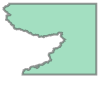

In [58]:
# cut french side from the italian bbox
it_to_keep = GY.bb2poly(bbfrit).difference(GY.frch)
it_to_keep

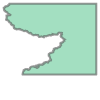

In [59]:
it_to_keep14 = it_to_keep.buffer(0.0006)
GY.sh2geojson(it_to_keep14, pjoin(workdir, 'it_to_keep14.geojson'))
it_to_keep14

In [24]:
it_to_keep15 = it_to_keep.buffer(0.0003)
GY.sh2geojson(it_to_keep15, pjoin(workdir, 'it_to_keep15.geojson'))

## Merge at z14/15/16

In [25]:
def runc(cmd):
    start = time()
    print(cmd)
    check_run(cmd)
    print(f'{time()-start:.1f} seconds')

In [53]:

z_to_process = (14,15,16)
optmulti = '-multi -wo NUM_THREADS=ALL_CPUS'

if 1-1:
    # this is what we would do if gdal was perfect:
    for zlevel in z_to_process:
        k = min(zlevel, 15) #16=15
        itvrt = f"{workdir}/it{zlevel}.vrt"
        runc(f'''gdalwarp -cutline {workdir}/it_to_keep{k}.geojson -crop_to_cutline \
            {mbtitcut} -oo ZOOM_LEVEL={zlevel} {itvrt} -overwrite''')
        mrg = f"{workdir}/mrg{zlevel}"
        runc(f'''gdalwarp {mbtfrclean} -oo ZOOM_LEVEL={zlevel} {itvrt} {mrg}.mbtiles -co TILE_FORMAT=JPEG -co QUALITY=95 -overwrite {optmulti}''')

# instead:
# * `itz = M.cut_zoom(...)` step added because gdal otherwise gets confused sometimes
# * `tif` workaround for gdal#7067

for zlevel in z_to_process:
    # generate vrt italian side
    k = min(zlevel, 15) #16=15
    itvrt = f"{workdir}/it{zlevel}.vrt"
    # itz = itvrt[:-4] + '.mbtiles'
    itz = M.cut_zoom(mbtitcut, zooms=[zlevel], overwrite=True)
    frvrt = f"{workdir}/fr{zlevel}.vrt"
    runc(f'''gdalwarp -cutline {workdir}/it_to_keep{k}.geojson -crop_to_cutline \
        {itz} -oo ZOOM_LEVEL={zlevel} {itvrt} -overwrite''')

    # apply on top of france, in 2 steps to work around issue gdal#7067
    mrg = f"{workdir}/mrg{zlevel}"
    runc(f'''gdalwarp {mbtfrclean} -oo ZOOM_LEVEL={zlevel} {itvrt} {mrg}.tif -co TILED=yes -overwrite {optmulti}''')
    os.unlink(itz)
    runc(f'''gdal_translate {mrg}.tif {mrg}.mbtiles -co TILE_FORMAT=JPEG -co QUALITY=95''')
    os.unlink(f'{mrg}.tif')
    mbt_info(mrg + '.mbtiles')

# for z16, ~20 minutes for the warp + 8 for the translate ; creates an intermediate 14 GB file :-|

z 15 : 6720
real bounds: LngLatBbox(west=6.767578125000016, south=44.02442151965934, east=8.173828124999986, north=44.590467181308846)
Fallback `center` to first tile:  12 2125 2613 6.811523437500016 44.43377142130676
itz frit1/itcutN-z15.mbtiles
gdalwarp -cutline frit1/it_to_keep15.geojson -crop_to_cutline         frit1/itcutN-z15.mbtiles -oo ZOOM_LEVEL=15 frit1/it15.vrt -overwrite
Using band 4 of source image as alpha.
Creating output file that is 45117P x 32786L.
Processing frit1/itcutN-z15.mbtiles [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
1.1 seconds
gdalwarp frit1/fr1-clean.mbtiles -oo ZOOM_LEVEL=15 frit1/it15.vrt frit1/mrg15.tif -co TILED=yes -overwrite 
Warning 6: driver VRT does not support open option ZOOM_LEVEL
Creating output file that is 57353P x 32789L.
Using band 4 of destination image as alpha.
Processing frit1/fr1-clean.mbtiles [1/2] : 0Using band 4 of source image as alpha.
...10...20...30...40...50...60...70...80...90...100 - done.
Processin

*(keeping output for future reference)*
<details>

```
z 15 : 6720
real bounds: LngLatBbox(west=6.767578125000016, south=44.02442151965934, east=8.173828124999986, north=44.590467181308846)
Fallback `center` to first tile:  12 2125 2613 6.811523437500016 44.43377142130676
gdalwarp -cutline frit1/it_to_keep15.geojson -crop_to_cutline         frit1/itcutN-z15.mbtiles -oo ZOOM_LEVEL=15 frit1/it15.vrt -overwrite
    Using band 4 of source image as alpha.
    Creating output file that is 45117P x 32786L.
    Processing frit1/itcutN-z15.mbtiles [1/1] 
    1.1 seconds
gdalwarp frit1/fr1-clean.mbtiles -oo ZOOM_LEVEL=15 frit1/it15.vrt frit1/mrg15.tif -co TILED=yes -overwrite 
    Warning 6: driver VRT does not support open option ZOOM_LEVEL
    Creating output file that is 57353P x 32789L.
    Using band 4 of destination image as alpha.
    Processing frit1/fr1-clean.mbtiles [1/2] : 0Using band 4 of source image as alpha.
    Processing frit1/it15.vrt [2/2] : 0Using band 4 of source image as alpha.
    340.4 seconds
gdal_translate frit1/mrg15.tif frit1/mrg15.mbtiles -co TILE_FORMAT=JPEG -co QUALITY=95
    Input file size is 57353, 32789
    216.5 seconds

z 16 : 26880
    real bounds: LngLatBbox(west=6.767578125000016, south=44.02442151965934, east=8.173828125000016, north=44.590467181308846)
    Fallback `center` to first tile:  12 2125 2613 6.811523437500016 44.43377142130676
gdalwarp -cutline frit1/it_to_keep15.geojson -crop_to_cutline         frit1/itcutN-z16.mbtiles -oo ZOOM_LEVEL=16 frit1/it16.vrt -overwrite
    Using band 4 of source image as alpha.
    Creating output file that is 90235P x 65574L.
    Processing frit1/itcutN-z16.mbtiles [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
    1.7 seconds
gdalwarp frit1/fr1-clean.mbtiles -oo ZOOM_LEVEL=16 frit1/it16.vrt frit1/mrg16.tif -co TILED=yes -overwrite 
    Warning 6: driver VRT does not support open option ZOOM_LEVEL
    Creating output file that is 114707P x 65581L.
    Using band 4 of destination image as alpha.
    Processing frit1/fr1-clean.mbtiles [1/2] : 0Using band 4 of source image as alpha.
    Processing frit1/it16.vrt [2/2] : 0Using band 4 of source image as alpha.
    2252.9 seconds
gdal_translate frit1/mrg16.tif frit1/mrg16.mbtiles -co TILE_FORMAT=JPEG -co QUALITY=95
    Input file size is 114707, 65581
    695.9 seconds
```

</details>

In [54]:
finalname = mbtnames_merged[fritN]
finalpath = pjoin(workdir, finalname + '.mbtiles')
# !rm $finalpath

mbt_merge(
    mbtitcut,
    mbtfrclean,
    pjoin(workdir, 'mrg14.mbtiles'),
    pjoin(workdir, 'mrg15.mbtiles'),
    pjoin(workdir, 'mrg16.mbtiles'),
    mbtbasemapclean,  # overrides z12 of mbtit
    dest=finalpath,
    name=finalname,
)

cp frit1/itcutN.mbtiles frit1/frit1-Mercantour-Ubaye-Cuneese.mbtiles
<<>> frit1/itcutN : zoom = 12 16 ; n = 35805 ; bounds = 6.76758,44.02442,8.17383,44.59047 ; center = 6.81152,44.43377,12 ; format = jpg ; name = Bugianen
<< frit1/fr1-clean : zoom = 9 16 ; n = 68819 ; bounds = 6.328,43.580,8.435,44.590 ; format = jpg ; name = IGNt1-Mercantour-Ubaye-Antibes-Embrun
>> frit1/frit1-Mercantour-Ubaye-Cuneese : zoom = 9 16 ; n = 92032 ; bounds = 6.76758,44.02442,8.17383,44.59047 ; center = 6.81152,44.43377,12 ; format = jpg ; name = Bugianen
<< frit1/mrg14 : zoom = 14 14 ; n = 4364 ; name = mrg14 ; format = jpg ; bounds = 6.32800000000000207,43.5798341324597587,8.78953831481933712,44.5910201107773787
>> frit1/frit1-Mercantour-Ubaye-Cuneese : zoom = 9 16 ; n = 92032 ; bounds = 6.76758,44.02442,8.17383,44.59047 ; center = 6.81152,44.43377,12 ; format = jpg ; name = Bugianen
<< frit1/mrg15 : zoom = 15 15 ; n = 17366 ; name = mrg15 ; format = jpg ; bounds = 6.32800000000000207,43.580020663165839

In [55]:
M.real_bounds(finalpath, log=print)

real bounds  9 [6.33, 43.58, 8.44, 44.59] 265 325 267 326
real bounds  10 [6.33, 43.58, 8.44, 44.59] 530 650 535 653
real bounds  11 [6.33, 43.58, 7.91, 44.59] 1060 1300 1068 1307
real bounds  12 [6.33, 43.58, 8.17, 44.59] 2120 2600 2140 2615
real bounds  13 [6.33, 43.58, 8.17, 44.59] 4240 5200 4281 5231
real bounds  14 [6.33, 43.58, 8.17, 44.59] 8480 10400 8563 10463
real bounds  15 [6.33, 43.58, 8.17, 44.59] 16960 20800 17127 20927
real bounds  16 [6.33, 43.58, 8.17, 44.59] 33920 41600 34255 41855


LngLatBbox(west=6.328124999999996, south=43.580390855607845, east=8.437500000000014, north=44.590467181308846)

In [56]:
description = finalname[6:] + ''' area, fusion de cartes IGN et Bugianen:
* IGN Top 25 et top 100 (2021)
* Bugianen 2205 : Mappa escursionistica delle alpi piemontesi, valdostane e dintorni.
Per la legenda e l'origine dei dati visita '''\
'<a href="https://tartamillo.wordpress.com/bugianen/">tartamillo.wordpress.com/bugianen/</a>.'
attribution = '© <a href="https://geoservices.ign.fr/cgu-licences">IGN 2021</a> '\
    '/ © <a href="https://tartamillo.wordpress.com/bugianen/">CC BY-NC-SA 3.0 Maki</a>'
M.update_mbt_meta(finalpath, name=finalname, desc=description, attrib=attribution)

In [57]:
M.get_meta(finalpath)

{'bounds': '6.32812,43.58039,8.4375,44.59047',
 'name': 'frit1-Mercantour-Ubaye-Cuneese',
 'type': 'baselayer',
 'version': '1.1',
 'description': 'Mercantour-Ubaye-Cuneese area, fusion de cartes IGN et Bugianen:\n* IGN Top 25 et top 100 (2021)\n* Bugianen 2205 : Mappa escursionistica delle alpi piemontesi, valdostane e dintorni.\nPer la legenda e l\'origine dei dati visita <a href="https://tartamillo.wordpress.com/bugianen/">tartamillo.wordpress.com/bugianen/</a>.',
 'format': 'jpg',
 'attribution': '© <a href="https://geoservices.ign.fr/cgu-licences">IGN 2021</a> / © <a href="https://tartamillo.wordpress.com/bugianen/">CC BY-NC-SA 3.0 Maki</a>',
 'maxzoom': '16',
 'minzoom': '12',
 'center': '7.38281,44.08543,9'}

In [24]:
#!gpxsee $finalpath